# Modeling similarity judgments with word embeddings

Previous work has illustrated that similarity judgments between words can be estimated using distributional models of word meaning. But are there certain kinds of words for which distributioanl information is more or less useful?

There are theoretical reasons to think that distributional information is more helpful for learning abstract concepts/words (Lupyan & Winter, 2018), and some empirical evidence as well (Kiros et al, 2018). But so far, others have not asked whether distributional information better predicts similarity judgments as a function of the *level of abstractness* of a word, or other kinds of semantic features. 

We use the Brysbaert norms as an estimate of concreteness, and ELMo as a model for word embeddings.

For the pairwise similarity judgments, we will consider several different datasets in turn.

In [152]:
import pandas as pd
from tqdm import tqdm
import itertools
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

## Load concreteness data

In [6]:
df_brysbaert = pd.read_csv("data/brysbaert_norms.csv")
len(df_brysbaert)

39954

In [7]:
df_brysbaert.head(5)

,Word,Bigram,Conc.M,Conc.SD,Unknown,Total,Percent_known,SUBTLEX,Dom_Pos
0,roadsweeper,0,4.85,0.37,1,27,0.96,0,0
1,traindriver,0,4.54,0.71,3,29,0.90,0,0
2,tush,0,4.45,1.01,3,25,0.88,66,0
3,hairdress,0,3.93,1.28,0,29,1.00,1,0
4,pharmaceutics,0,3.77,1.41,4,26,0.85,0,0


In [10]:
# For each word in Brysbaert norms, build a dictionary mapping that word onto its concreteness rating.
word_to_cnc = {}
for index, row in df_brysbaert.iterrows():
    word = row['Word']
    cnc = row['Conc.M']
    word_to_cnc[word] = cnc

## Load Elmo

We will use ELMo as a model for word embeddings.

In [11]:
from allennlp.commands.elmo import ElmoEmbedder

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [12]:
elmo = ElmoEmbedder()

## SimVerb

The first dataset to consider is **SimVerb-3500**.

### Load data

In [224]:
df_sim = pd.read_csv("data/simverb/SimVerb-3500.txt", sep="\t")
len(df_sim)

3500

In [225]:
df_sim.sort_values("Sim", ascending=False).head(5)

,w1,w2,PO,Sim,Relation
617,rip,tear,V,9.96,HYPER/HYPONYMS
1230,build,construct,V,9.96,SYNONYMS
1556,repair,fix,V,9.96,SYNONYMS
476,understand,comprehend,V,9.79,HYPER/HYPONYMS
355,flee,escape,V,9.79,HYPER/HYPONYMS


In [226]:
all_verbs = list(df_sim['w1']) + list(df_sim['w2'])
len(set(all_verbs))

827

### Get concreteness ratings

In [17]:
def get_conc(word, mapping):
    """Try to get concreteness rating."""
    try:
        return mapping[word]
    except Exception as e:
        return None

In [12]:
df_sim['w1_conc'] = df_sim['w1'].apply(lambda x: get_conc(x, word_to_cnc))
df_sim['w2_conc'] = df_sim['w2'].apply(lambda x: get_conc(x, word_to_cnc))

### Get pairwise similarities from ELMo

In [76]:
similarities = []
for index, row in tqdm(list(df_sim.iterrows())):
    w1, w2 = row['w1'], row['w2']
    
    w1_embedding = elmo.embed_sentence([w1])[0][0].tolist()
    w2_embedding = elmo.embed_sentence([w2])[0][0].tolist()
    
    sim = scipy.spatial.distance.cosine(w1_embedding, w2_embedding)
    
    similarities.append(sim)

100%|██████████| 3500/3500 [28:58<00:00,  3.26it/s]


In [78]:
df_sim['decontextualized_elmo_similarity'] = similarities

In [181]:
df_sim = df_sim.dropna()

In [182]:
df_sim.to_csv("data/processed/sim3500_with_cosine_distance.csv")

### Predict similarities

Now we predict similarity judgments with ELMo cosine distances.

In [183]:
import statsmodels.formula.api as sm

In [184]:
df_sim = pd.read_csv("data/processed/sim3500_with_cosine_distance.csv")

In [185]:
result = sm.ols(formula="similarity ~ decontextualized_elmo_similarity", data=df_sim).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             similarity   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     711.0
Date:                Tue, 29 Oct 2019   Prob (F-statistic):          1.02e-142
Time:                        14:30:41   Log-Likelihood:                -8025.5
No. Observations:                3487   AIC:                         1.606e+04
Df Residuals:                    3485   BIC:                         1.607e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           12.6248      0.315     40.047      0.000      12.007      13.243
decontextualized_elmo_similarity   -10.1372      0.380    -26.665      0.000     -10.883      -9.392
==============================================================================
Omnibus:                      168.345   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.177
Skew:                          -0.086   Prob(JB):                     3.50e-16
Kurtosis:                       2.322   Cond. No.                         15.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

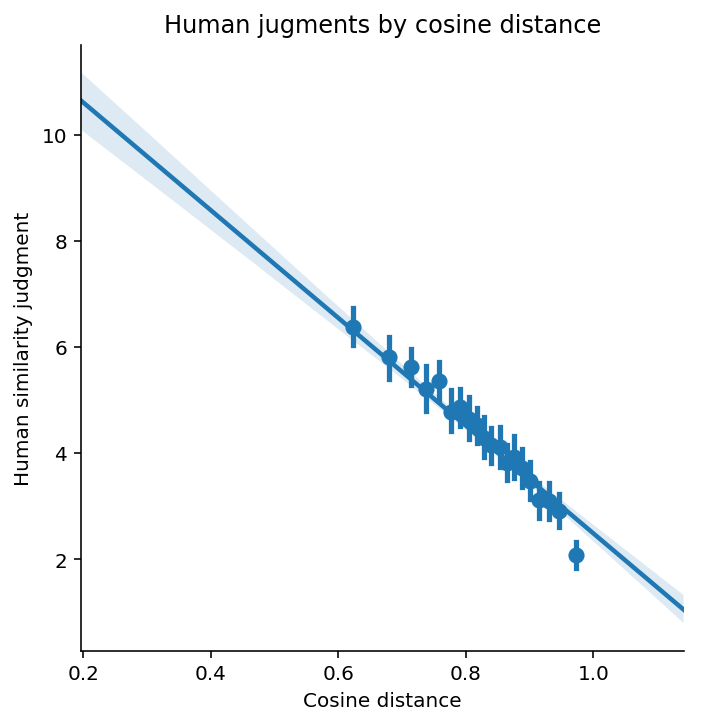

In [168]:
sns.lmplot(data = df_sim,
          x = "decontextualized_elmo_similarity",
          y = "similarity",
          x_bins = 20)
plt.xlabel("Cosine distance")
plt.ylabel("Human similarity judgment")
plt.title("Human jugments by cosine distance")
plt.savefig("Figures/simverb_overall.png", dpi=300)

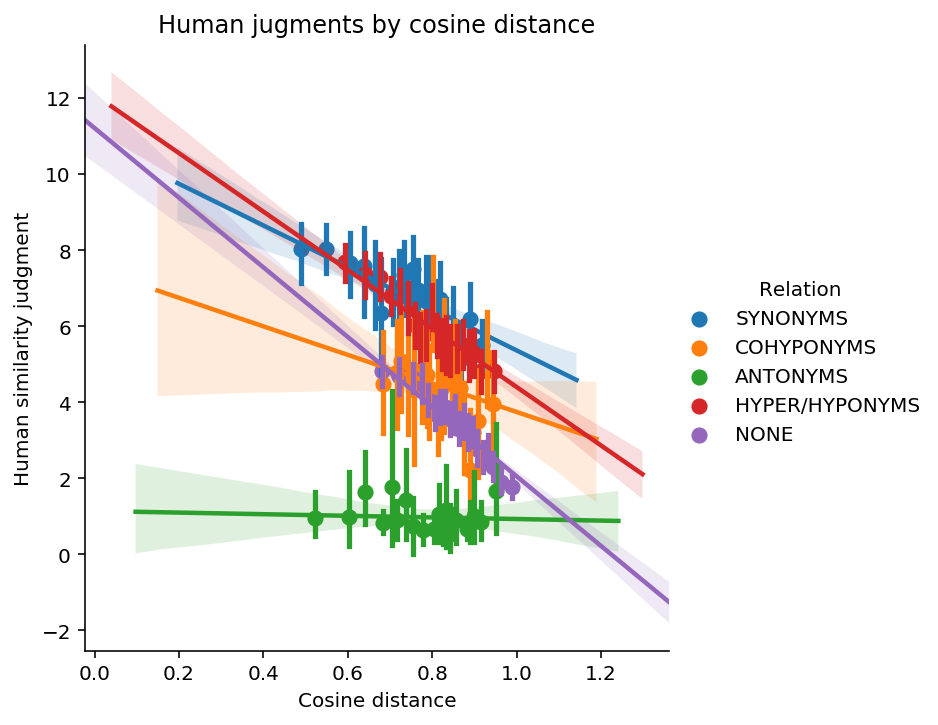

In [169]:
sns.lmplot(data = df_sim,
          x = "decontextualized_elmo_similarity",
          y = "similarity",
          hue = 'Relation',
          x_bins = 20)
plt.xlabel("Cosine distance")
plt.ylabel("Human similarity judgment")
plt.title("Human jugments by cosine distance")
plt.savefig("Figures/simverb_with_relation.png", dpi=300)

### Is prediction better for abstract words?

In [186]:
combined = list(df_sim['w1_conc']) +  list(df_sim['w2_conc'])
median_conc = statistics.median(combined)
median_conc

3.03

In [60]:
def get_comparison_type(row):
    if row['w1_is_abstract'] and row['w2_is_abstract']:
        return "Abstract"
    elif not row['w1_is_abstract'] and not row['w2_is_abstract']:
        return "Concrete"
    return "Mixed"

In [188]:
df_sim['w1_is_abstract'] = df_sim['w1_conc'].apply(lambda x: x < median_conc)
df_sim['w2_is_abstract'] = df_sim['w2_conc'].apply(lambda x: x < median_conc)
df_sim['same'] = df_sim['w1_is_abstract'] == df_sim['w2_is_abstract']

In [189]:
df_sim['Comparison Type'] = df_sim.apply(lambda row: get_comparison_type(row), axis=1)

In [196]:
print("#Abstract: {n}".format(n=len(df_sim[df_sim['Comparison Type']=='Abstract'])))
print("#Concrete: {n}".format(n=len(df_sim[df_sim['Comparison Type']=='Concrete'])))
print("#Mixed: {n}".format(n=len(df_sim[df_sim['Comparison Type']=='Mixed'])))



#Abstract: 1164
#Concrete: 1179
#Mixed: 1144


In [191]:
result = sm.ols(formula="similarity ~ decontextualized_elmo_similarity", 
                data=df_sim[df_sim['Comparison Type']=='Abstract']).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             similarity   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     236.2
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           1.16e-48
Time:                        14:31:46   Log-Likelihood:                -2690.7
No. Observations:                1164   AIC:                             5385.
Df Residuals:                    1162   BIC:                             5396.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           12.1756      0.496     24.562      0.000      11.203      13.148
decontextualized_elmo_similarity    -9.4439      0.614    -15.369      0.000     -10.650      -8.238
==============================================================================
Omnibus:                       26.262   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.296
Skew:                          -0.233   Prob(JB):                     3.92e-05
Kurtosis:                       2.551   Cond. No.                         14.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [192]:
result = sm.ols(formula="similarity ~ decontextualized_elmo_similarity", 
                data=df_sim[df_sim['Comparison Type']=='Concrete']).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             similarity   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     137.4
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           4.39e-30
Time:                        14:31:51   Log-Likelihood:                -2719.1
No. Observations:                1179   AIC:                             5442.
Df Residuals:                    1177   BIC:                             5452.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           11.1218      0.591     18.823      0.000       9.963      12.281
decontextualized_elmo_similarity    -8.3681      0.714    -11.720      0.000      -9.769      -6.967
==============================================================================
Omnibus:                      208.933   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.428
Skew:                          -0.013   Prob(JB):                     1.37e-10
Kurtosis:                       2.039   Cond. No.                         16.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [193]:
result = sm.ols(formula="similarity ~ decontextualized_elmo_similarity", 
                data=df_sim[df_sim['Comparison Type']=='Mixed']).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             similarity   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     325.0
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           3.96e-64
Time:                        14:31:59   Log-Likelihood:                -2604.2
No. Observations:                1144   AIC:                             5212.
Df Residuals:                    1142   BIC:                             5222.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           14.5331      0.589     24.654      0.000      13.376      15.690
decontextualized_elmo_similarity   -12.4545      0.691    -18.027      0.000     -13.810     -11.099
==============================================================================
Omnibus:                       37.217   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.660
Skew:                          -0.010   Prob(JB):                     0.000146
Kurtosis:                       2.392   Cond. No.                         17.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Human jugments by cosine distance')

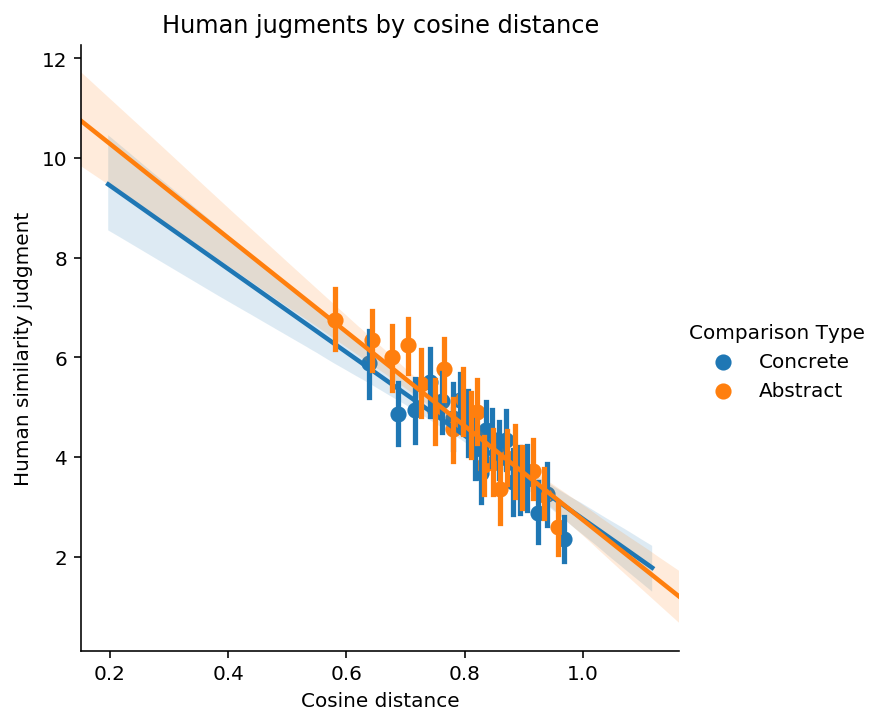

In [202]:
sns.lmplot(data = df_sim[df_sim['Comparison Type']!="Mixed"],
          x = "decontextualized_elmo_similarity",
          y = "similarity",
           hue = "Comparison Type",
          x_bins = 20
          )
plt.xlabel("Cosine distance")
plt.ylabel("Human similarity judgment")
plt.title("Human jugments by cosine distance")
# plt.savefig("Figures/simverb_overall.png", dpi=300)

## WordSim-353

### Load data

In [227]:
df_wordsim = pd.read_csv("data/wordsim353/combined.csv")
len(df_wordsim)

353

In [228]:
df_wordsim['similarity'] = df_wordsim['Human (mean)']

In [15]:
df_wordsim.head(5)

,Word 1,Word 2,Human (mean)
0,love,sex,6.77
1,tiger,cat,7.35
2,tiger,tiger,10.00
3,book,paper,7.46
4,computer,keyboard,7.62


In [229]:
all_words = list(df_wordsim['Word 1']) + list(df_wordsim['Word 2'])
len(all_words)

706

### Get concreteness ratings

In [18]:
df_wordsim['w1_conc'] = df_wordsim['Word 1'].apply(lambda x: get_conc(x, word_to_cnc))
df_wordsim['w2_conc'] = df_wordsim['Word 2'].apply(lambda x: get_conc(x, word_to_cnc))

In [19]:
df_wordsim.head(5)

,Word 1,Word 2,Human (mean),w1_conc,w2_conc
0,love,sex,6.77,2.07,4.10
1,tiger,cat,7.35,5.00,4.86
2,tiger,tiger,10.00,5.00,5.00
3,book,paper,7.46,4.90,4.93
4,computer,keyboard,7.62,4.93,4.93


### Get pairwise similarities from ELMo

In [20]:
similarities = []
for index, row in tqdm(list(df_wordsim.iterrows())):
    w1, w2 = row['Word 1'], row['Word 2']
    
    w1_embedding = elmo.embed_sentence([w1])[0][0].tolist()
    w2_embedding = elmo.embed_sentence([w2])[0][0].tolist()
    
    sim = scipy.spatial.distance.cosine(w1_embedding, w2_embedding)
    
    similarities.append(sim)

100%|██████████| 353/353 [01:44<00:00,  3.32it/s]


In [22]:
df_wordsim['decontextualized_elmo_similarity'] = similarities

In [23]:
df_wordsim.to_csv("data/processed/wordsim_with_cosine_distance.csv")

### Predict similarities

Now we predict similarity judgments with ELMo cosine distances.

#### Overall: how well do distributional cues predict similarity judgments?

In [203]:
import statsmodels.formula.api as sm

In [207]:
df_wordsim = pd.read_csv("data/processed/wordsim_with_cosine_distance.csv")
df_wordsim['similarity'] = df_wordsim['Human (mean)']

In [208]:
result = sm.ols(formula="similarity ~ decontextualized_elmo_similarity", data=df_wordsim).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             similarity   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     145.3
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           3.12e-28
Time:                        14:35:27   Log-Likelihood:                -713.62
No. Observations:                 353   AIC:                             1431.
Df Residuals:                     351   BIC:                             1439.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           12.6329      0.571     22.138      0.000      11.511      13.755
decontextualized_elmo_similarity    -8.3129      0.690    -12.053      0.000      -9.669      -6.957
==============================================================================
Omnibus:                       16.029   Durbin-Watson:                   1.225
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.456
Skew:                          -0.543   Prob(JB):                     0.000162
Kurtosis:                       2.923   Cond. No.                         11.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


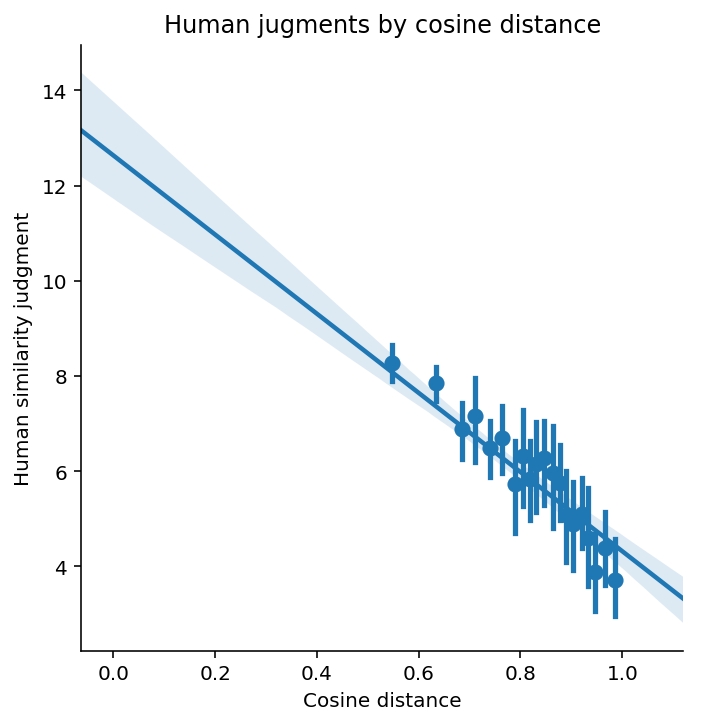

In [36]:
sns.lmplot(data = df_wordsim,
          x = "decontextualized_elmo_similarity",
          y = "similarity",
          x_bins = 20)
plt.xlabel("Cosine distance")
plt.ylabel("Human similarity judgment")
plt.title("Human jugments by cosine distance")
plt.savefig("Figures/wordsim_overall.png", dpi=300)

### Do distributional cues better predict judgments of abstract vs. concrete words?

In [213]:
combined = list(df_wordsim['w1_conc']) +  list(df_wordsim['w2_conc'])
median_conc = statistics.median(combined)
median_conc

3.94

In [214]:
df_wordsim['w1_is_abstract'] = df_wordsim['w1_conc'].apply(lambda x: x < median_conc)
df_wordsim['w2_is_abstract'] = df_wordsim['w2_conc'].apply(lambda x: x < median_conc)
df_wordsim['same'] = df_wordsim['w1_is_abstract'] == df_wordsim['w2_is_abstract']

In [215]:
def get_comparison_type(row):
    if row['w1_is_abstract'] and row['w2_is_abstract']:
        return "Abstract"
    elif not row['w1_is_abstract'] and not row['w2_is_abstract']:
        return "Concrete"
    return "Mixed"

In [216]:
df_wordsim['Comparison Type'] = df_wordsim.apply(lambda row: get_comparison_type(row), axis=1)

In [217]:
print("#Abstract: {n}".format(n=len(df_wordsim[(df_wordsim['w1_is_abstract']==True)&(df_wordsim['w2_is_abstract']==True)])))
print("#Concrete: {n}".format(n=len(df_wordsim[(df_wordsim['w1_is_abstract']==False)&(df_wordsim['w2_is_abstract']==False)])))
print("#Different (abstract vs. concrete): {n}".format(n=len(df_wordsim[df_wordsim['same']==False])))


#Abstract: 101
#Concrete: 138
#Different (abstract vs. concrete): 114


In [218]:
result = sm.ols(formula="similarity ~ decontextualized_elmo_similarity", 
                data=df_wordsim[df_wordsim['Comparison Type']=="Abstract"]).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             similarity   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     56.80
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           2.33e-11
Time:                        14:36:11   Log-Likelihood:                -183.78
No. Observations:                 101   AIC:                             371.6
Df Residuals:                      99   BIC:                             376.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           12.5975      0.957     13.168      0.000      10.699      14.496
decontextualized_elmo_similarity    -8.4989      1.128     -7.537      0.000     -10.736      -6.261
==============================================================================
Omnibus:                        0.352   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.839   Jarque-Bera (JB):                0.520
Skew:                          -0.047   Prob(JB):                        0.771
Kurtosis:                       2.662   Cond. No.                         12.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [219]:
result = sm.ols(formula="similarity ~ decontextualized_elmo_similarity", 
                data=df_wordsim[df_wordsim['Comparison Type']=="Concrete"]).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             similarity   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     45.25
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           4.41e-10
Time:                        14:36:16   Log-Likelihood:                -288.74
No. Observations:                 138   AIC:                             581.5
Df Residuals:                     136   BIC:                             587.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           12.2495      0.881     13.907      0.000      10.508      13.991
decontextualized_elmo_similarity    -7.7684      1.155     -6.727      0.000     -10.052      -5.485
==============================================================================
Omnibus:                       17.358   Durbin-Watson:                   1.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.363
Skew:                          -0.935   Prob(JB):                     3.79e-05
Kurtosis:                       3.207   Cond. No.                         10.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [220]:
result = sm.ols(formula="similarity ~ decontextualized_elmo_similarity", 
                data=df_wordsim[df_wordsim['Comparison Type']=='Mixed']).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             similarity   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     31.21
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           1.64e-07
Time:                        14:36:31   Log-Likelihood:                -235.23
No. Observations:                 114   AIC:                             474.5
Df Residuals:                     112   BIC:                             479.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           13.8600      1.508      9.188      0.000      10.871      16.849
decontextualized_elmo_similarity    -9.5542      1.710     -5.587      0.000     -12.943      -6.166
==============================================================================
Omnibus:                        2.768   Durbin-Watson:                   1.290
Prob(Omnibus):                  0.251   Jarque-Bera (JB):                2.785
Skew:                          -0.348   Prob(JB):                        0.248
Kurtosis:                       2.679   Cond. No.                         16.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Human jugments by cosine distance')

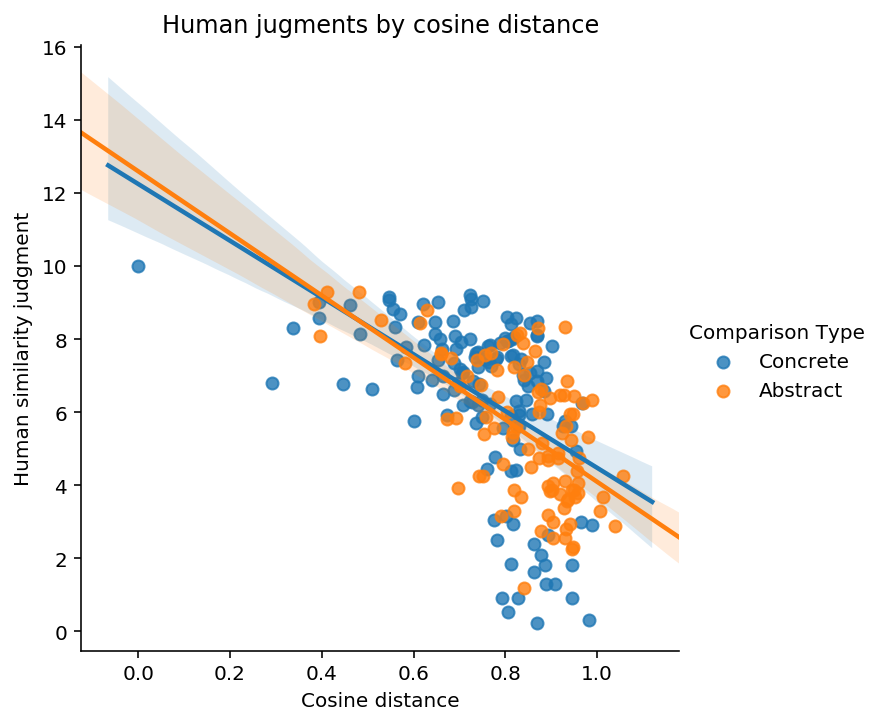

In [222]:
sns.lmplot(data = df_wordsim[df_wordsim['Comparison Type']!="Mixed"],
          x = "decontextualized_elmo_similarity",
          y = "similarity",
          hue = 'Comparison Type',
          # x_bins = 20
          )
plt.xlabel("Cosine distance")
plt.ylabel("Human similarity judgment")
plt.title("Human jugments by cosine distance")
# plt.savefig("Figures/wordsim_concrete.png", dpi=300)

## SimLex-999

### Load data

In [230]:
df_simlex = pd.read_csv("data/SimLex-999/SimLex-999.txt", sep="\t")
len(df_simlex)

999

In [231]:
df_simlex.head(5)

,word1,word2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex)
0,old,new,A,1.58,2.72,2.81,2,7.25,1,0.41
1,smart,intelligent,A,9.20,1.75,2.46,1,7.11,1,0.67
2,hard,difficult,A,8.77,3.76,2.21,2,5.94,1,1.19
3,happy,cheerful,A,9.55,2.56,2.34,1,5.85,1,2.18
4,hard,easy,A,0.95,3.76,2.07,2,5.82,1,0.93


In [232]:
df_simlex['similarity'] = df_simlex['SimLex999']

In [233]:
combined = list(df_simlex['word1']) + list(df_simlex['word2'])
len(set(combined))

1028

### Get concreteness ratings

`SimLex` already has concreteness data associated with each word. Though we will also check this against the Brysbaert data, just to be consistent. (They should both be sourced from Brysbaert.)

In [104]:
df_simlex['w1_conc'] = df_simlex['word1'].apply(lambda x: get_conc(x, word_to_cnc))
df_simlex['w2_conc'] = df_simlex['word2'].apply(lambda x: get_conc(x, word_to_cnc))

In [105]:
df_simlex.head(5)

,word1,word2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex),w1_conc,w2_conc
0,old,new,A,1.58,2.72,2.81,2,7.25,1,0.41,2.72,2.81
1,smart,intelligent,A,9.20,1.75,2.46,1,7.11,1,0.67,1.75,2.46
2,hard,difficult,A,8.77,3.76,2.21,2,5.94,1,1.19,3.76,2.21
3,happy,cheerful,A,9.55,2.56,2.34,1,5.85,1,2.18,2.56,2.34
4,hard,easy,A,0.95,3.76,2.07,2,5.82,1,0.93,3.76,2.07


In [111]:
# The concreteness ratings are identical in every case
df_simlex['w1_same_conc'] = df_simlex['w1_conc']==df_simlex['conc(w1)']
'False' in df_simlex['w1_same_conc']

False

### Get pairwise similarities from ELMo

In [136]:
similarities = []
for index, row in tqdm(list(df_simlex.iterrows())):
    w1, w2 = row['word1'], row['word2']
    
    w1_embedding = elmo.embed_sentence([w1])[0][0].tolist()
    w2_embedding = elmo.embed_sentence([w2])[0][0].tolist()

    sim = scipy.spatial.distance.cosine(w1_embedding, w2_embedding)
    
    similarities.append(sim)

100%|██████████| 999/999 [05:58<00:00,  2.34it/s]


In [137]:
df_simlex['decontextualized_elmo_similarity'] = similarities

In [138]:
df_simlex.to_csv("data/processed/simlex_with_cosine_distance.csv")

### Predict similarities

Now we predict similarity judgments with ELMo cosine distances.

#### Overall: how well do distributional cues predict similarity judgments?

In [234]:
import statsmodels.formula.api as sm

In [235]:
df_simlex = pd.read_csv("data/processed/simlex_with_cosine_distance.csv")

In [236]:
result = sm.ols(formula="similarity ~ decontextualized_elmo_similarity", data=df_simlex).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             similarity   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     199.4
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           2.05e-41
Time:                        15:06:47   Log-Likelihood:                -2286.1
No. Observations:                 999   AIC:                             4576.
Df Residuals:                     997   BIC:                             4586.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           10.3722      0.418     24.794      0.000       9.551      11.193
decontextualized_elmo_similarity    -7.7350      0.548    -14.122      0.000      -8.810      -6.660
==============================================================================
Omnibus:                       80.283   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.901
Skew:                          -0.101   Prob(JB):                     8.74e-07
Kurtosis:                       2.207   Cond. No.                         11.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


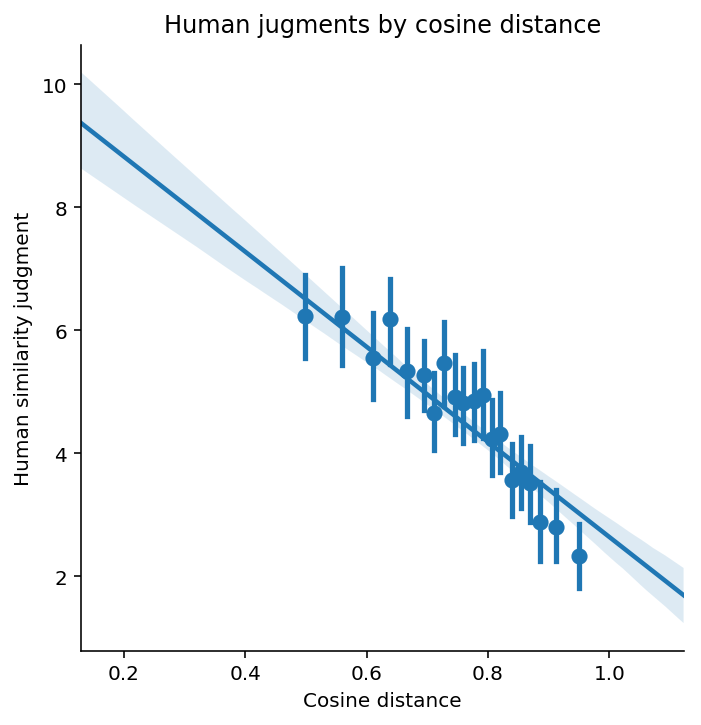

In [143]:
sns.lmplot(data = df_simlex,
          x = "decontextualized_elmo_similarity",
          y = "similarity",
          x_bins = 20)
plt.xlabel("Cosine distance")
plt.ylabel("Human similarity judgment")
plt.title("Human jugments by cosine distance")
plt.savefig("Figures/simlex_overall.png", dpi=300)

### Do distributional cues better predict judgments of abstract vs. concrete words?

In [237]:
combined = list(df_simlex['w1_conc']) +  list(df_simlex['w2_conc'])
median_conc = statistics.median(combined)

In [238]:
df_simlex['w1_is_abstract'] = df_simlex['w1_conc'].apply(lambda x: x < median_conc)
df_simlex['w2_is_abstract'] = df_simlex['w2_conc'].apply(lambda x: x < median_conc)
df_simlex['same'] = df_simlex['w1_is_abstract'] == df_simlex['w2_is_abstract']

In [239]:
df_simlex['Comparison Type'] = df_simlex.apply(lambda row: get_comparison_type(row), axis=1)

In [240]:
print("#Abstract: {n}".format(n=len(df_simlex[(df_simlex['w1_is_abstract']==True)&(df_simlex['w2_is_abstract']==True)])))
print("#Concrete: {n}".format(n=len(df_simlex[(df_simlex['w1_is_abstract']==False)&(df_simlex['w2_is_abstract']==False)])))
print("#Different (abstract vs. concrete): {n}".format(n=len(df_simlex[df_simlex['same']==False])))


#Abstract: 433
#Concrete: 434
#Different (abstract vs. concrete): 132


In [241]:
result = sm.ols(formula="similarity ~ decontextualized_elmo_similarity", 
                data=df_simlex[df_simlex['Comparison Type']=="Abstract"]).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             similarity   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     87.89
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           3.95e-19
Time:                        15:06:58   Log-Likelihood:                -1022.6
No. Observations:                 433   AIC:                             2049.
Df Residuals:                     431   BIC:                             2057.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           11.6599      0.723     16.135      0.000      10.240      13.080
decontextualized_elmo_similarity    -8.8413      0.943     -9.375      0.000     -10.695      -6.988
==============================================================================
Omnibus:                       23.148   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.529
Skew:                          -0.441   Prob(JB):                     5.75e-05
Kurtosis:                       2.449   Cond. No.                         12.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [242]:
result = sm.ols(formula="similarity ~ decontextualized_elmo_similarity", 
                data=df_simlex[df_simlex['Comparison Type']=="Concrete"]).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             similarity   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     80.76
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           8.00e-18
Time:                        15:07:00   Log-Likelihood:                -941.36
No. Observations:                 434   AIC:                             1887.
Df Residuals:                     432   BIC:                             1895.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            9.1636      0.549     16.694      0.000       8.085      10.242
decontextualized_elmo_similarity    -6.6496      0.740     -8.987      0.000      -8.104      -5.195
==============================================================================
Omnibus:                       25.542   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.762
Skew:                           0.118   Prob(JB):                      0.00460
Kurtosis:                       2.265   Cond. No.                         11.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [243]:
result = sm.ols(formula="similarity ~ decontextualized_elmo_similarity", 
                data=df_simlex[df_simlex['Comparison Type']=="Mixed"]).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             similarity   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     44.11
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           7.69e-10
Time:                        15:07:02   Log-Likelihood:                -296.92
No. Observations:                 132   AIC:                             597.8
Df Residuals:                     130   BIC:                             603.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           11.6680      1.175      9.928      0.000       9.343      13.993
decontextualized_elmo_similarity    -9.4680      1.426     -6.641      0.000     -12.288      -6.648
==============================================================================
Omnibus:                        3.435   Durbin-Watson:                   1.452
Prob(Omnibus):                  0.180   Jarque-Bera (JB):                2.098
Skew:                           0.003   Prob(JB):                        0.350
Kurtosis:                       2.382   Cond. No.                         11.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

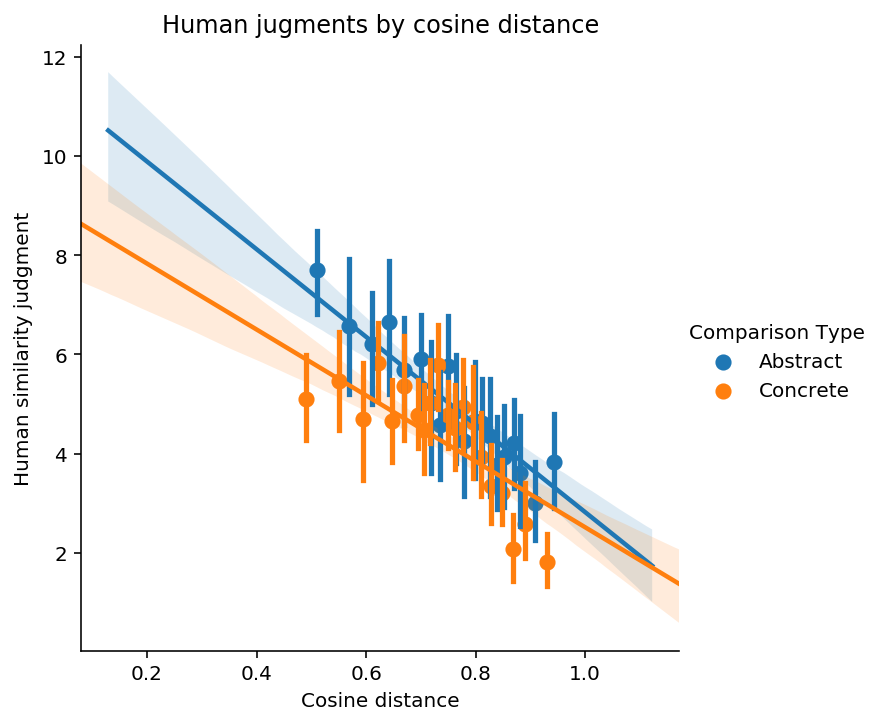

In [263]:
sns.lmplot(data = df_simlex[df_simlex['Comparison Type']!="Mixed"],
          x = "decontextualized_elmo_similarity",
          y = "similarity",
          hue = 'Comparison Type',
          x_bins = 20
          )
plt.xlabel("Cosine distance")
plt.ylabel("Human similarity judgment")
plt.title("Human jugments by cosine distance")
plt.savefig("Figures/simlex_both.png", dpi=300)